## Library

In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_community.retrievers import BM25Retriever
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_teddynote.messages import stream_response
from dotenv import load_dotenv
from matplotlib import font_manager, rc
from collections import Counter
import platform
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
sample_df = pd.read_json("../data/판례_21-23년/2021가소10678.json", orient='index').T
sample_df

,판례일련번호,사건명,사건번호,선고일자,법원명,법원종류코드,사건종류명,사건종류코드,판결유형,선고,판례상세링크,판시사항,판결요지,참조조문,참조판례,판례내용
0,231053,손해배상(기),2021가소10678,2022-04-05,부산지방법원,None,민사,400101,판결 : 확정,선고,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,【판시사항】\n갑이 아파트 경비용역업무를 수행하는 을 주식회사와 기간제 근로계약을 ...,【판결요지】\n갑이 아파트 경비용역업무를 수행하는 을 주식회사와 기간제 근로계약을 ...,【참조조문】\n근로기준법 제23조 제1항,None,【원고】 원고 (소송대리인 공익법무관 정재훈)\n【피고】 주식회사 장천 (소송대리인...


In [3]:
# json_dir = "../data/판례_21-23년/"
# output_base_dir = "../data/" 
# yearly_dfs = {}

# all_files = os.listdir(json_dir)
# json_files = [f for f in all_files if f.endswith('.json')]

# for json_file in json_files:
#     file_path = os.path.join(json_dir, json_file)
    
#     # 파일 이름에서 연도 추출 (예: 2021가소10678.json -> 2021)
#     match = re.match(r'(\d{4})', json_file)
#     if match:
#         year = match.group(1)
#     else:
#         print(f"Warning: Could not extract year from {json_file}. Skipping.")
#         continue

#     try:
#         df = pd.read_json(file_path, orient='index').T
#         if year not in yearly_dfs:
#             yearly_dfs[year] = []
#         yearly_dfs[year].append(df)
        
#     except ValueError as e:
#         print(f"Error reading {file_path}: {e}")

# # 연도별 CSV로 저장
# for year, dfs in yearly_dfs.items():
#     if dfs:
#         combined_df_yearly = pd.concat(dfs, ignore_index=True)
#         output_csv_path = os.path.join(output_base_dir, f"cases_{year}.csv")
#         combined_df_yearly.to_csv(output_csv_path, index=False)
#         print(f"Combined {len(dfs)} JSON files for year {year} into {output_csv_path}")
#     else:
#         print(f"No JSON files were successfully combined for year {year}.")

# print("All yearly JSON files processed and saved to CSVs.")

In [4]:
output_base_dir = "../data/" 
df_2021 = pd.read_csv(os.path.join(output_base_dir, "cases_2021.csv"))
df_2022 = pd.read_csv(os.path.join(output_base_dir, "cases_2022.csv"))
df_2023 = pd.read_csv(os.path.join(output_base_dir, "cases_2023.csv"))
df = pd.read_csv(os.path.join(output_base_dir, "cases_2021_2023.csv"))
# df = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)
# df.to_csv(os.path.join(output_base_dir, "cases_2021_2023.csv"), index=False)

print(f"2021 DataFrame shape: {df_2021.shape}")
print(f"2022 DataFrame shape: {df_2022.shape}")
print(f"2023 DataFrame shape: {df_2023.shape}")
print(f"DataFrame shape (2021-2023): {df.shape}")
df.head(3)

2021 DataFrame shape: (34, 16)
2022 DataFrame shape: (16, 16)
2023 DataFrame shape: (1, 16)
DataFrame shape (2021-2023): (51, 16)


,판례일련번호,사건명,사건번호,선고일자,법원명,법원종류코드,사건종류명,사건종류코드,판결유형,선고,판례상세링크,판시사항,판결요지,참조조문,참조판례,판례내용
0,227067,유족급여및장의비부지급처분취소,2021두34275,2021-10-14,대법원,NaN,일반행정,400107.0,판결,선고,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,【판시사항】\n[1] 근로자가 자해행위로 사망하였으나 업무와 사망 사이에 인과관계를...,【판결요지】\n[1] 근로자가 업무상의 사유 그 자체 또는 업무상의 재해로 말미암아...,"【참조조문】\n[1]산업재해보상보험법 제37조 제1항,제2항,구 산업재해보상보험법 ...","【참조판례】\n[1]대법원 2014. 10. 30. 선고 2011두14692 판결,...","【원고, 상고인】 원고\n【피고, 피상고인】 근로복지공단\n【원심판결】 서울고법 2..."
1,401646,서울남부지방법원 2022. 2. 14. 선고 2021노957 판결 [근로기준법위반],2021노957,2022-02-14,서울남부지방법원,NaN,근로_임금,NaN,판결,선고,NaN,NaN,NaN,NaN,NaN,서울남부지방법원 2022. 2. 14. 선고 2021노957 판결 [근로기준법위반]...
2,223823,체육지도자자격취소처분취소의소,2021두62287,2022-07-14,대법원,NaN,일반행정,400107.0,판결,선고,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,【판시사항】\n체육지도자의 자격취소에 관한 구 국민체육진흥법 제12조 제1항 제4호...,【판결요지】\n구 국민체육진흥법(2020. 2. 4. 법률 제16931호로 개정되기...,【참조조문】\n구 국민체육진흥법(2020. 2. 4. 법률 제16931호로 개정되기...,NaN,"【원고, 피상고인】 원고 (소송대리인 법무법인 호림 담당변호사 온성욱 외 2인)\n..."


In [5]:
# font
path = '/library/Fonts/Arial Unicode.ttf'

if platform.system() == 'Darwin':
    print('Hangul OK in your MAC!')
    rc('font', family='Arial Unicode MS')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.. sorry')
plt.rcParams['axes.unicode_minus'] = False

# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count', show_legend=False):
    plt.figure(figsize=figsize)
    order = df[col].value_counts().index
    ax = sns.countplot(data=df, x=col, hue=col, palette=palette, order=order)
    
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    
    # show_legend 매개변수에 따라 범례 처리
    if show_legend:
        # 범례가 존재하면 제목 설정
        if ax.legend_ is not None:
            ax.legend_.set_title(col)
    else:
        # show_legend가 False이면 범례 제거
        if ax.legend_ is not None:
            ax.legend_.remove()            
    plt.show()

# bar_plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title if title else f'{x_col}별 {y_col}')
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# box_plot
def box_plot(df1, col, df2=None, figsize=(8, 6), color1='skyblue', color2='salmon', title=None):
    plt.figure(figsize=figsize)

    if df2 is None:
        # 단일 데이터프레임 boxplot
        sns.boxplot(y=df1[col], color=color1)  # 개별일 때는 color1 (기본값 skyblue)
        plt.ylabel(col)
        plt.title(title if title else f'{col} (Box Plot)')
    else:
        # 두 데이터프레임 비교 boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df1[col], color=color1)  # 첫 번째 그룹은 color1
        plt.ylabel(col)
        plt.title(f'Group 1 - {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df2[col], color=color2)  # 두 번째 그룹은 color2
        plt.ylabel(col)
        plt.title(f'Group 2 - {col}')

        plt.suptitle(title if title else f'{col} Comparison (Box Plot)', fontsize=12)

    plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, ax=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None, subplot_title=None):
    if ax is None: # ax가 제공되지 않으면 새로운 figure와 axes를 생성
        fig, ax = plt.subplots(figsize=figsize)
    
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None), ax=ax)
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2', ax=ax)
        ax.legend()  # 두 그룹일 때만 범례 표시

    ax.set_title(subplot_title if subplot_title else (title if title else f'{col} Distribution (Histogram + KDE)'))
    ax.set_xlabel(col)
    ax.set_ylabel('Count') 
    
    if ax is None: # ax가 제공되지 않았을 때만 show 호출
        plt.show()


# corr_heatmap
def corr_heatmap(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

Hangul OK in your MAC!


In [6]:
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"Column '{col}': Single unique value.")
        print(df[col].unique())

Column '선고': Single unique value.
['선고']


In [7]:
# 필요 없는 컬럼 제거
df = df.drop(columns=['선고'])
df.shape

(51, 15)

### Document Length Analysis

In [8]:
df['판시사항_글자수'] = df['판시사항'].astype(str).apply(len)
df['판결요지_글자수'] = df['판결요지'].astype(str).apply(len)
df['판례내용_글자수'] = df['판례내용'].astype(str).apply(len)

df['판시사항_단어수'] = df['판시사항'].astype(str).apply(lambda x: len(x.split()))
df['판결요지_단어수'] = df['판결요지'].astype(str).apply(lambda x: len(x.split()))
df['판례내용_단어수'] = df['판례내용'].astype(str).apply(lambda x: len(x.split()))
df.head(3)

,판례일련번호,사건명,사건번호,선고일자,법원명,법원종류코드,사건종류명,사건종류코드,판결유형,판례상세링크,...,판결요지,참조조문,참조판례,판례내용,판시사항_글자수,판결요지_글자수,판례내용_글자수,판시사항_단어수,판결요지_단어수,판례내용_단어수
0,227067,유족급여및장의비부지급처분취소,2021두34275,2021-10-14,대법원,NaN,일반행정,400107.0,판결,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,...,【판결요지】\n[1] 근로자가 업무상의 사유 그 자체 또는 업무상의 재해로 말미암아...,"【참조조문】\n[1]산업재해보상보험법 제37조 제1항,제2항,구 산업재해보상보험법 ...","【참조판례】\n[1]대법원 2014. 10. 30. 선고 2011두14692 판결,...","【원고, 상고인】 원고\n【피고, 피상고인】 근로복지공단\n【원심판결】 서울고법 2...",529,942,4787,131,227,1074
1,401646,서울남부지방법원 2022. 2. 14. 선고 2021노957 판결 [근로기준법위반],2021노957,2022-02-14,서울남부지방법원,NaN,근로_임금,NaN,판결,NaN,...,NaN,NaN,NaN,서울남부지방법원 2022. 2. 14. 선고 2021노957 판결 [근로기준법위반]...,3,3,8410,1,1,1970
2,223823,체육지도자자격취소처분취소의소,2021두62287,2022-07-14,대법원,NaN,일반행정,400107.0,판결,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,...,【판결요지】\n구 국민체육진흥법(2020. 2. 4. 법률 제16931호로 개정되기...,【참조조문】\n구 국민체육진흥법(2020. 2. 4. 법률 제16931호로 개정되기...,NaN,"【원고, 피상고인】 원고 (소송대리인 법무법인 호림 담당변호사 온성욱 외 2인)\n...",193,339,3147,41,74,705


- 글자 수 분석

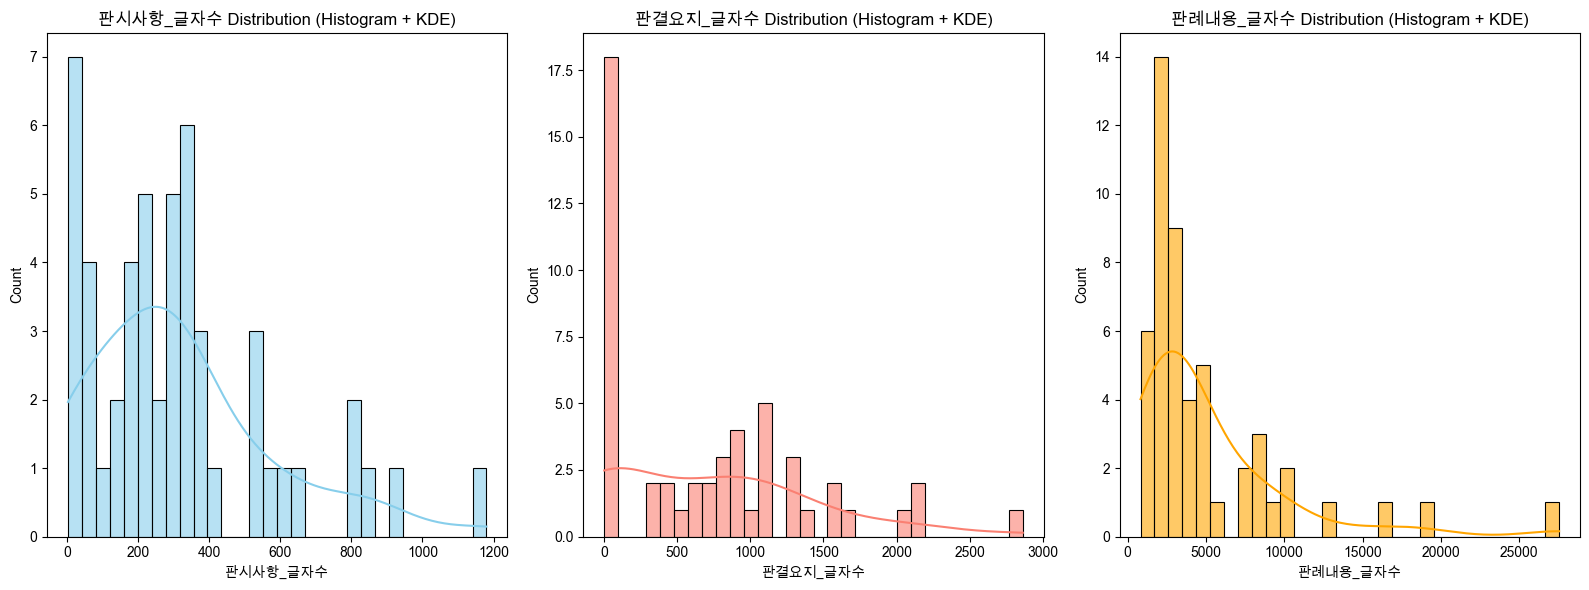

,판시사항_글자수,판결요지_글자수,판례내용_글자수
count,51.000000,51.000000,51.000000
mean,315.431373,718.294118,5049.333333
std,263.037279,708.659673,5000.985841
min,3.000000,3.000000,818.000000
25%,134.500000,3.000000,2261.000000
50%,282.000000,696.000000,3147.000000
75%,380.500000,1095.000000,5673.000000
max,1180.000000,2861.000000,27549.000000


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
hist_plot(df1=df, col='판시사항_글자수', ax=axes[0])
hist_plot(df1=df, col='판결요지_글자수', ax=axes[1], color1='salmon')
hist_plot(df1=df, col='판례내용_글자수', ax=axes[2], color1='orange')
plt.tight_layout()
plt.show()

df[['판시사항_글자수', '판결요지_글자수', '판례내용_글자수']].describe()

- 단어 수 분석

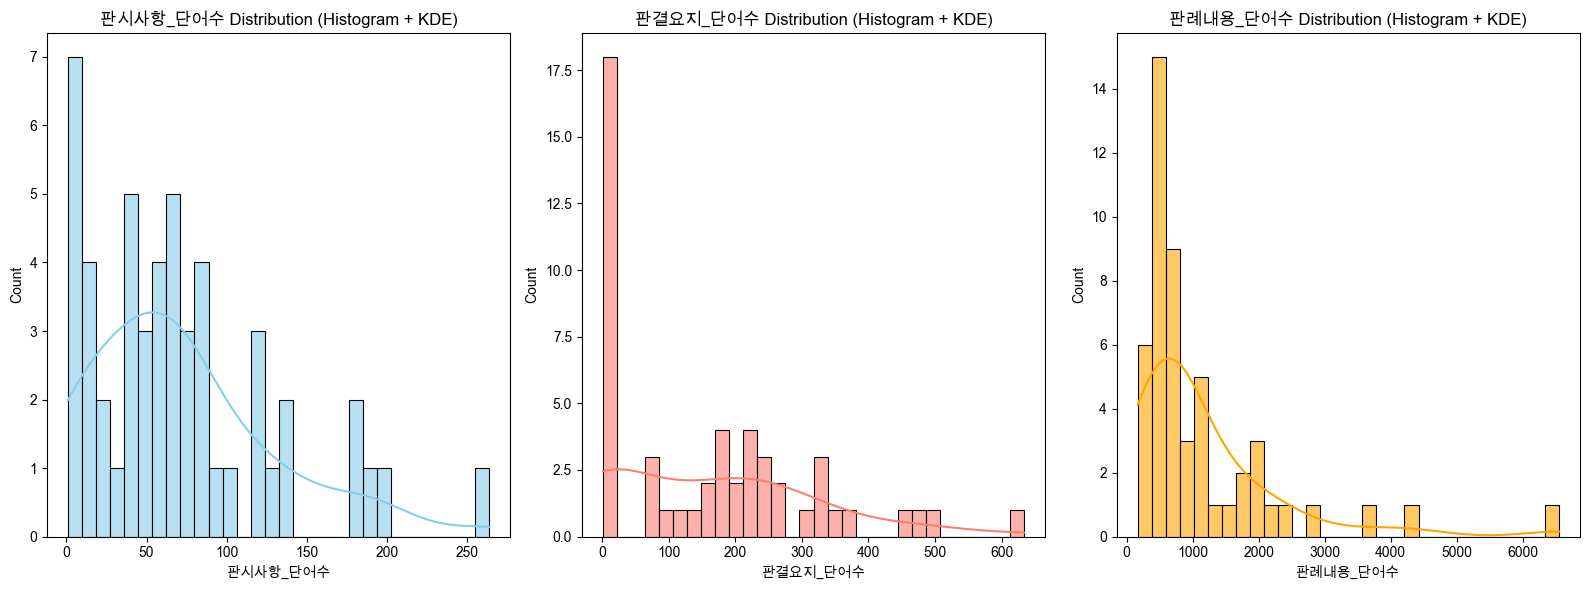

,판시사항_단어수,판결요지_단어수,판례내용_단어수
count,51.000000,51.000000,51.000000
mean,70.843137,162.450980,1147.137255
std,58.935345,158.709334,1173.667790
min,1.000000,1.000000,168.000000
25%,28.000000,1.000000,501.500000
50%,62.000000,156.000000,705.000000
75%,89.500000,248.500000,1263.000000
max,264.000000,634.000000,6548.000000


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
hist_plot(df1=df, col='판시사항_단어수', ax=axes[0])
hist_plot(df1=df, col='판결요지_단어수', ax=axes[1], color1='salmon')
hist_plot(df1=df, col='판례내용_단어수', ax=axes[2], color1='orange')
plt.tight_layout()
plt.show()

df[['판시사항_단어수', '판결요지_단어수', '판례내용_단어수']].describe()

### Meta Data Analysis

In [16]:
df.head(3)

,판례일련번호,사건명,사건번호,선고일자,법원명,법원종류코드,사건종류명,사건종류코드,판결유형,판례상세링크,...,판결요지,참조조문,참조판례,판례내용,판시사항_글자수,판결요지_글자수,판례내용_글자수,판시사항_단어수,판결요지_단어수,판례내용_단어수
0,227067,유족급여및장의비부지급처분취소,2021두34275,2021-10-14,대법원,NaN,일반행정,400107.0,판결,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,...,【판결요지】\n[1] 근로자가 업무상의 사유 그 자체 또는 업무상의 재해로 말미암아...,"【참조조문】\n[1]산업재해보상보험법 제37조 제1항,제2항,구 산업재해보상보험법 ...","【참조판례】\n[1]대법원 2014. 10. 30. 선고 2011두14692 판결,...","【원고, 상고인】 원고\n【피고, 피상고인】 근로복지공단\n【원심판결】 서울고법 2...",529,942,4787,131,227,1074
1,401646,서울남부지방법원 2022. 2. 14. 선고 2021노957 판결 [근로기준법위반],2021노957,2022-02-14,서울남부지방법원,NaN,근로_임금,NaN,판결,NaN,...,NaN,NaN,NaN,서울남부지방법원 2022. 2. 14. 선고 2021노957 판결 [근로기준법위반]...,3,3,8410,1,1,1970
2,223823,체육지도자자격취소처분취소의소,2021두62287,2022-07-14,대법원,NaN,일반행정,400107.0,판결,/DRF/lawService.do?OC=pwshoot&target=prec&ID=2...,...,【판결요지】\n구 국민체육진흥법(2020. 2. 4. 법률 제16931호로 개정되기...,【참조조문】\n구 국민체육진흥법(2020. 2. 4. 법률 제16931호로 개정되기...,NaN,"【원고, 피상고인】 원고 (소송대리인 법무법인 호림 담당변호사 온성욱 외 2인)\n...",193,339,3147,41,74,705


In [11]:
def value_cnt(df, col):
    df_cnt = df[col].value_counts().reset_index()
    df_cnt.columns = [col, 'count']
    df_cnt = df_cnt.sort_values(by='count', ascending=False).reset_index(drop=True)
    return df_cnt

- 사건명 분석

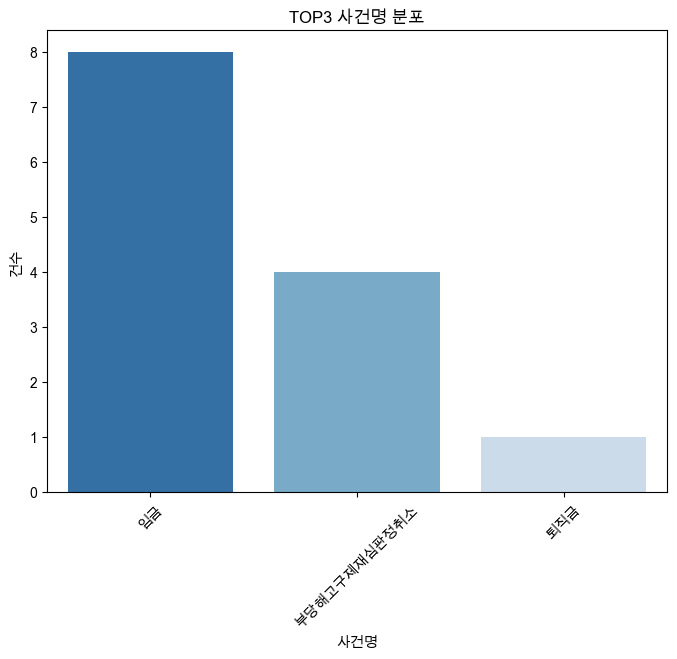

,사건명,count
0,임금,8
1,부당해고구제재심판정취소,4
2,퇴직금,1
3,근로자지위확인등,1
4,지방공무원법위반[임용권자가 승진임용에 관한 부당한 영향을 미쳤는지가 문제된 사건],1


In [15]:
case_name = value_cnt(df=df, col='사건명')
bar_plot(df=case_name.head(3), x_col='사건명', y_col='count', figsize=(8, 6), 
         rotation=45, title='TOP3 사건명 분포', xlabel='사건명', ylabel='건수')
case_name.head()

- 사건종류명 분석

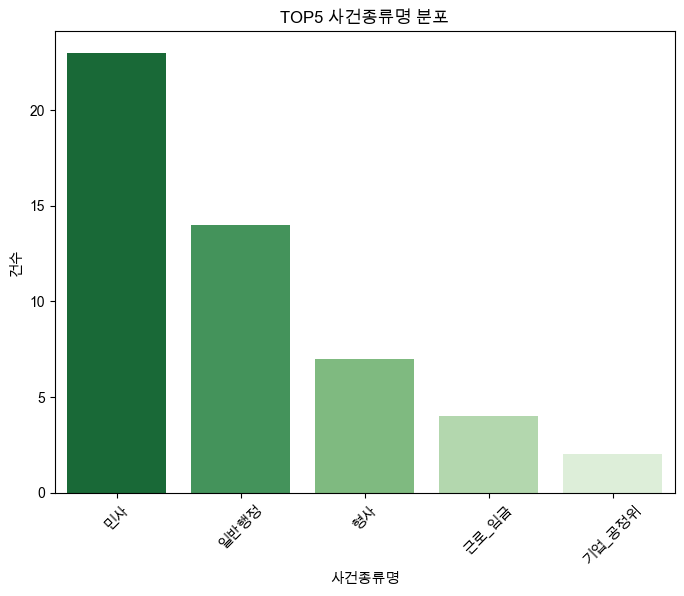

,사건종류명,count
0,민사,23
1,일반행정,14
2,형사,7
3,근로_임금,4
4,기업_공정위,2


In [18]:
case_type_name = value_cnt(df=df, col='사건종류명')
bar_plot(df=case_type_name.head(), x_col='사건종류명', y_col='count', figsize=(8, 6), 
         rotation=45, title='TOP5 사건종류명 분포', xlabel='사건종류명', ylabel='건수', palette='Greens_r')
case_type_name.head()

- 판결유형 분석

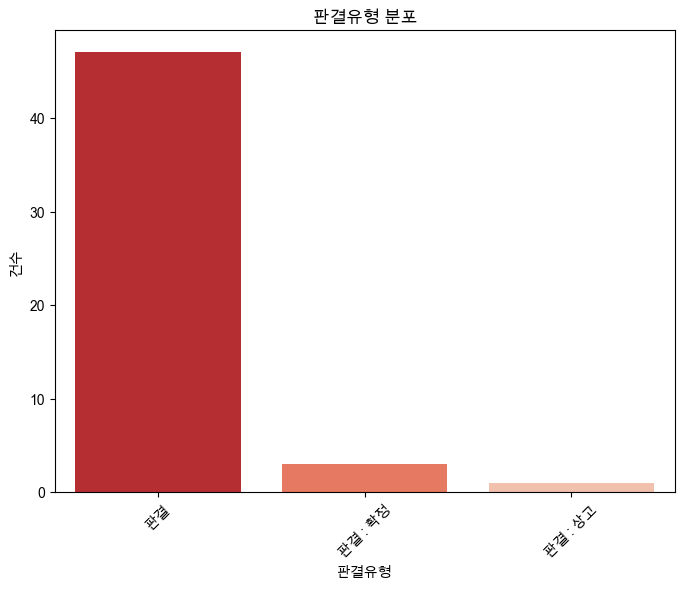

,판결유형,count
0,판결,47
1,판결 : 확정,3
2,판결 : 상고,1


In [20]:
judgment_type = value_cnt(df=df, col='판결유형')
bar_plot(df=judgment_type.head(), x_col='판결유형', y_col='count', figsize=(8, 6), 
         rotation=45, title='판결유형 분포', xlabel='판결유형', ylabel='건수', palette='Reds_r')
judgment_type.head()

In [31]:
def get_laws(df, col, n=10, return_df=False):
    """참조조문에서 주요 법령 추출 & 빈도 분석"""
    laws = []
    
    for text in df[col].dropna():
        found = re.findall(r'[가-힣]+법|[가-힣]+령|[가-힣]+규칙', str(text))
        laws.extend(found)
    counter = Counter(laws)

    if return_df:
        return counter
    else:
        print(f"주요 법령 TOP {n}:")
        for law, count in counter.most_common(n):
            print(f"  {law}: {count}회")

- 참조조문 & 판례내용 분석

In [34]:
get_laws(df=df, col='참조조문', n=10)
print("\n")
get_laws(df=df, col='판례내용', n=10)

주요 법령 TOP 10:
  근로기준법: 39회
  산업재해보상보험법: 13회
  시행령: 12회
  민법: 10회
  개발법: 7회
  시행규칙: 6회
  대통령령: 4회
  보장법: 4회
  사립학교법: 4회
  변호사법: 3회


주요 법령 TOP 10:
  대법: 255회
  근로기준법: 165회
  취업규칙: 96회
  파견법: 52회
  위법: 50회
  법무법: 49회
  방법: 44회
  적법: 42회
  법령: 42회
  불법: 37회
